Training Set:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Test Set:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Tai

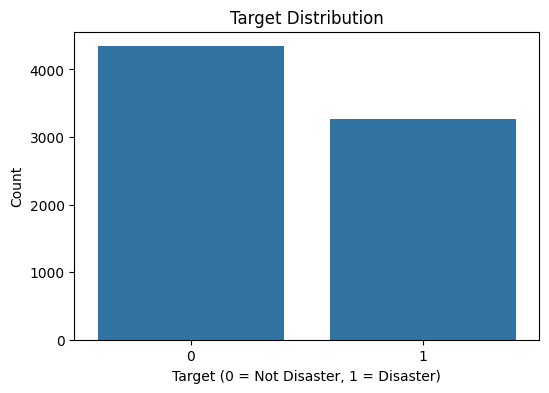

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Display first few rows of the training set
print("Training Set:")
print(train.head())

# Display first few rows of the test set
print("\nTest Set:")
print(test.head())

# Check for missing values in the training set
print("\nMissing values in training set:")
print(train.isnull().sum())

# Check for missing values in the test set
print("\nMissing values in test set:")
print(test.isnull().sum())

# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Target Distribution')
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()


In [2]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fill missing values
train['keyword'].fillna('Unknown', inplace=True)
train['location'].fillna('Unknown', inplace=True)
test['keyword'].fillna('Unknown', inplace=True)
test['location'].fillna('Unknown', inplace=True)

# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the clean_text function to the 'text' column
train['cleaned_text'] = train['text'].apply(clean_text)
test['cleaned_text'] = test['text'].apply(clean_text)

# Display the first few rows to check
print("Training Set with Cleaned Text:")
print(train[['text', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-2-865fa254abef>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['keyword'].fillna('Unknown', inplace=True)
<ipython-input-2-865fa254abef>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

Training Set with Cleaned Text:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  got sent photo ruby alaska smoke wildfires pou...  


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit and transform the training data; transform the test data
X_train = tfidf.fit_transform(train['cleaned_text']).toarray()
X_test = tfidf.transform(test['cleaned_text']).toarray()

# Get the target variable
y_train = train['target'].values

# Display the shape of the transformed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (7613, 5000)
Shape of X_test: (3263, 5000)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

# Split the data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

F1 Score: 0.7404902789518174


In [5]:
# Predict on the test set
test_predictions = model.predict(X_test)

# Create a submission DataFrame
submission = pd.DataFrame({'id': test['id'], 'target': test_predictions})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")


Submission file created successfully.


In [6]:
import numpy as np

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_index[word] = vector

# Check the size of the loaded embeddings
print("Number of words in GloVe embeddings:", len(embedding_index))


Number of words in GloVe embeddings: 400001


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the maximum number of words and the embedding dimension
MAX_NB_WORDS = 5000
EMBEDDING_DIM = 100  # GloVe 100d

# Tokenize and fit on the training data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['cleaned_text'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test['cleaned_text'])

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=50)  # Adjust maxlen as needed
X_test_pad = pad_sequences(X_test_seq, maxlen=50)

# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_NB_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (5000, 100)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

# Model parameters
embedding_dim = EMBEDDING_DIM
max_sequence_length = 50  # Same as the maxlen in padding

# Build the model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, batch_size=64, epochs=5, validation_split=0.2, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.6812 - loss: 0.5966 - val_accuracy: 0.7938 - val_loss: 0.4532
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.7837 - loss: 0.4818 - val_accuracy: 0.7958 - val_loss: 0.4424
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7768 - loss: 0.4809 - val_accuracy: 0.7925 - val_loss: 0.4452
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7884 - loss: 0.4651 - val_accuracy: 0.7997 - val_loss: 0.4410
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7965 - loss: 0.4480 - val_accuracy: 0.8056 - val_loss: 0.4372


In [9]:
# Predict on the test set
test_predictions = (model.predict(X_test_pad) > 0.5).astype("int32")

# Create a submission DataFrame
submission = pd.DataFrame({'id': test['id'], 'target': test_predictions.flatten()})

# Save the submission file
submission.to_csv('submission_lstm.csv', index=False)
print("Submission file created successfully.")


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Submission file created successfully.


In [10]:
import torch
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
def tokenize_data(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Apply tokenization to train and test sets
train_encodings = tokenize_data(train['text'].tolist())
test_encodings = tokenize_data(test['text'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
from transformers import BertForSequenceClassification, AdamW

# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Convert labels to tensor
labels = torch.tensor(train['target'].values)

# Create dataset and data loader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [13]:
# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        # Move batch to device
        batch = [item.to(device) for item in batch]
        input_ids, attention_mask, labels = batch

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Loss: 0.4352
Epoch 2/3 - Loss: 0.3144
Epoch 3/3 - Loss: 0.2328


In [14]:
# Switch to evaluation mode
model.eval()

# Tokenize test data for BERT and move it to the device
with torch.no_grad():
    test_inputs = test_encodings['input_ids'].to(device)
    test_masks = test_encodings['attention_mask'].to(device)

    # Get predictions
    outputs = model(test_inputs, attention_mask=test_masks)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Create a submission DataFrame
submission = pd.DataFrame({'id': test['id'], 'target': predictions})
submission.to_csv('submission_bert.csv', index=False)
print("Submission file created successfully.")


Submission file created successfully.
